In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join
from scikitplot.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (20, 10)

In [35]:
gal_types = np.array(['Elliptical', 'Spiral', 'Starforming'])
sfh_types = np.array(['Exponentially declining', 'Delayed exponential'])

sed_class = dict(
    Ell1_A_0 = (0, 0, 0.3),
    Ell2_A_0 = (0, 0, 0.3),
    Ell3_A_0 = (0, 0, 0.7),
    Ell4_A_0 = (0, 0, 0.7),
    Ell5_A_0 = (0, 0, 1.5),
    Ell6_A_0 = (0, 0, 1.5),
    Ell7_A_0 = (0, 0, 2.5),
    S0_A_0   = (1, 0, 2.5),
    Sa_A_0   = (1, 0, 5.0),
    Sa_A_1   = (1, 0, 5.0),
    Sb_A_0   = (1, 0, 5.0),
    Sb_A_1   = (1, 0, 5.0),
    Sc_A_0   = (1, 0, 10.0),
    Sc_A_1   = (1, 0, 10.0),
    Sc_A_2   = (1, 0, 10.0),
    Sd_A_0   = (1, 1, 0.3),
    Sd_A_1   = (1, 1, 0.3),
    Sd_A_2   = (1, 1, 0.3),
    Sdm_A_0  = (1, 1, 0.3),
    SB0_A_0  = (2, 1, 1.5),
    SB10_A_0 = (2, 1, 10.0),
    SB11_A_0 = (2, 1, 10.0),
    SB1_A_0  = (2, 1, 2.5),
    SB2_A_0  = (2, 1, 2.5),
    SB3_A_0  = (2, 1, 2.5),
    SB4_A_0  = (2, 1, 2.5),
    SB5_A_0  = (2, 1, 5.0),
    SB6_A_0  = (2, 1, 5.0),
    SB7_A_0  = (2, 1, 5.0),
    SB8_A_0  = (2, 1, 5.0),
    SB9_A_0  = (2, 1, 10.0),
)

In [36]:
target_gals = Table.read('/home/aalvarez/Phosphoros/Results/WillPP/Target/phz_cat.fits')

In [37]:
ref_gal_type = []
ref_sfh_type = []
ref_sfh_tau = []
for sed in target_gals['SED']:
    sed = sed.split('/')[1].strip()
    gal_type, sfh_type, sfh_tau = sed_class[sed]
    ref_gal_type.append(gal_type)
    ref_sfh_type.append(sfh_type)
    ref_sfh_tau.append(sfh_tau)
ref_gal_type = np.array(ref_gal_type)
ref_sfh_type = np.array(ref_sfh_type)
ref_sfh_tau = np.array(ref_sfh_tau)

In [38]:
hdulist = fits.open('/home/aalvarez/Work/Data/WillPP/TargetPP.fits', hdu=1)
t = Table(hdulist[1].data)

In [39]:
target = Table.read('/home/aalvarez/Work/Data/WillPP/Target.fits')
target.add_column(Column(ref_gal_type, 'GAL_TYPE'))
target.add_column(Column(ref_sfh_type, 'SFH_TYPE'))
target.add_column(Column(ref_sfh_tau, 'SFH_TAU'))

In [40]:
merged = join(t, target, 'ID')
zdif = merged['REDSHIFT_MEDIAN'][:,0] - merged['Z']

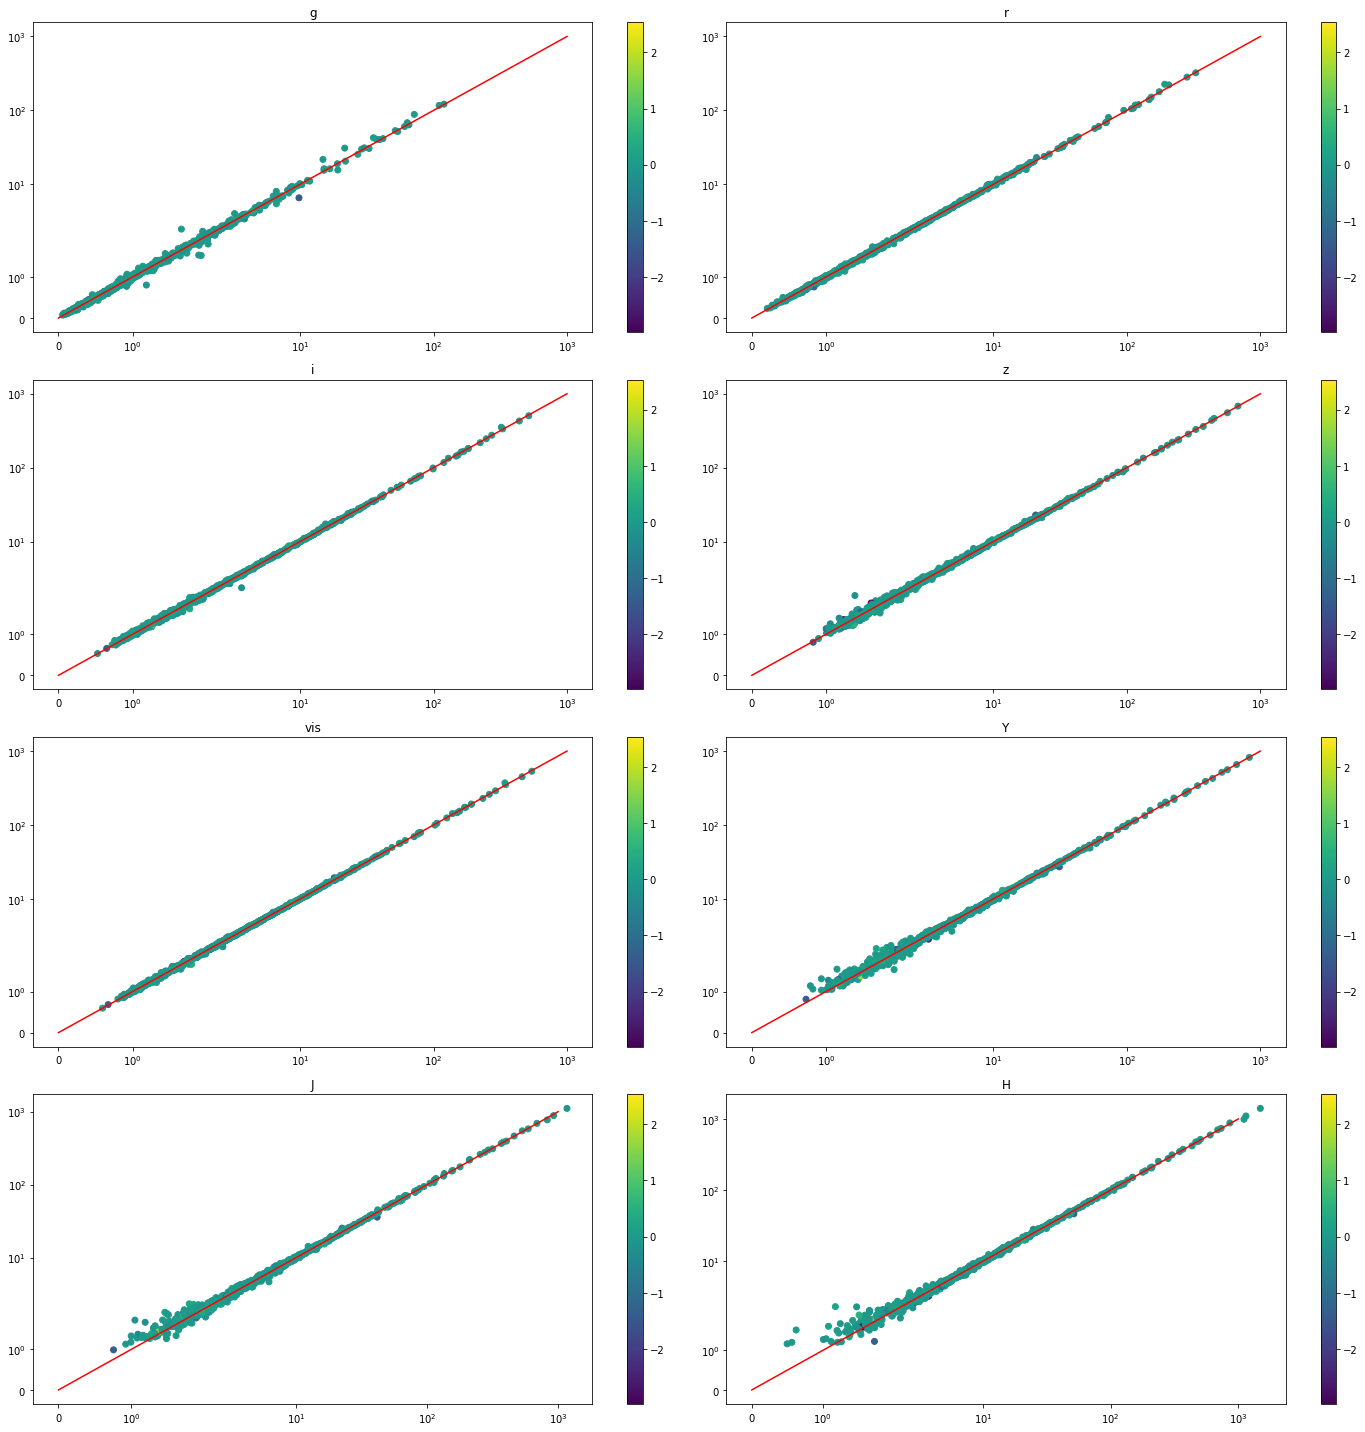

In [8]:
bands = ['g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']

fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2 + len(bands)%2, figsize=(20,20))

for b, ax in zip(bands, axes.ravel()):
    sc = ax.scatter(merged[f'Flux_{b}'], merged[f'Flux_{b}_MEAN'], c=zdif)
    ax.plot([0, 1e3], [0, 1e3], c='red')
    plt.colorbar(sc, ax=ax)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_title(b)
plt.tight_layout()

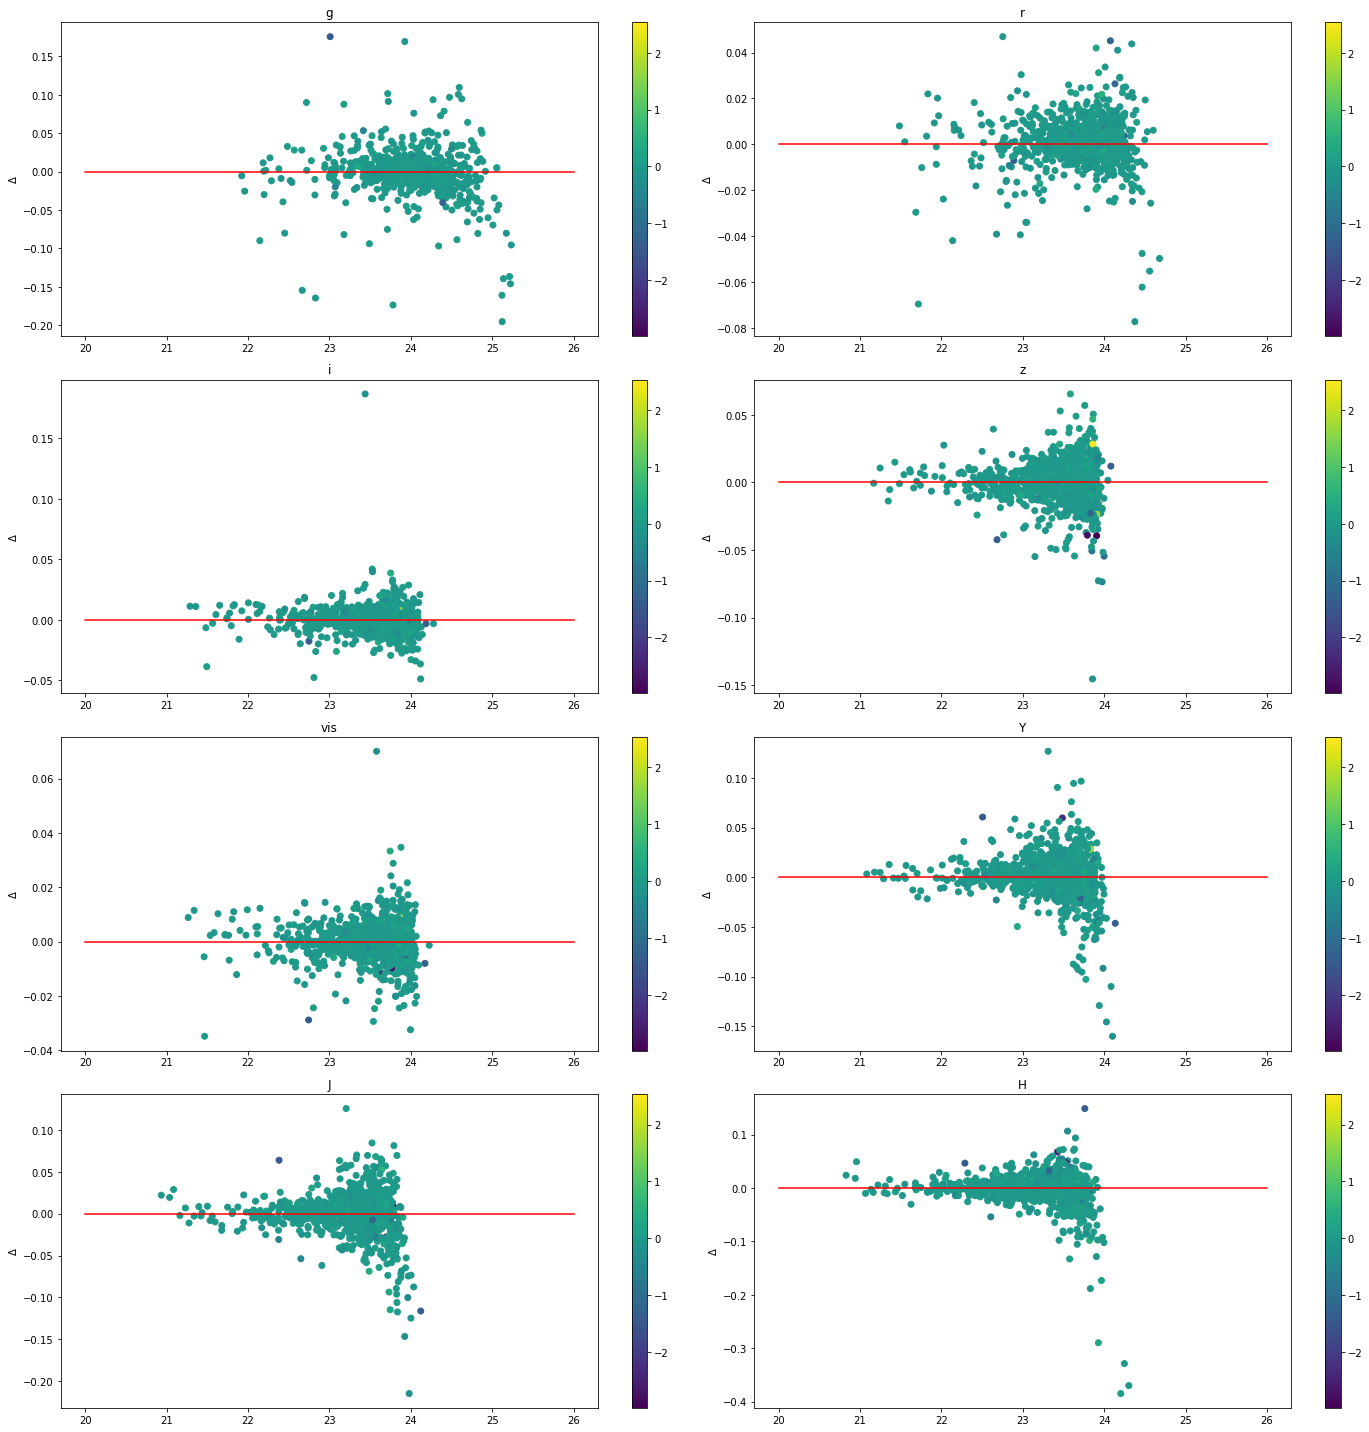

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2 + len(bands)%2, figsize=(20,20))

for b, ax in zip(bands, axes.ravel()):
    sc = ax.scatter(
        24-np.log10(merged[f'Flux_{b}']),
        np.log10(merged[f'Flux_{b}'])-np.log10(merged[f'Flux_{b}_MEAN']),
        c=zdif
    )
    ax.plot([20, 26], [0, 0], c='red')
    plt.colorbar(sc, ax=ax)
    ax.set_ylabel('$\Delta$')
    ax.set_title(b)
plt.tight_layout()

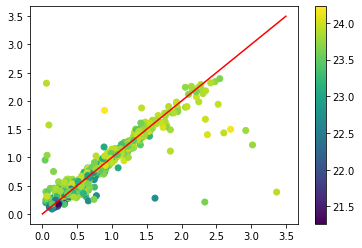

In [10]:
plt.figure()
plt.scatter(merged['Z'], merged['REDSHIFT_MEAN'], c=24-np.log10(merged['Flux_vis']))
plt.plot([0,3.5], [0,3.5], c='red')
plt.colorbar()

In [11]:
original = np.load('/home/aalvarez/Work/Data/WillPP/mc_data_0.npy', mmap_mode='r')
origi_pdz = np.load('/home/aalvarez/Work/Data/WillPP/pdz_data_0.npy', mmap_mode='r')

In [12]:
idx = np.arange(len(t))
np.random.shuffle(idx)

In [13]:
def plot_pp_pdf(name, nobjects=7):
    fig, axes = plt.subplots(ncols=2, nrows=nobjects, figsize=(20, 20))
    fig.suptitle(name)

    bins = hdulist[f'BINS_MC_PDF_1D_{name}'].data['BINS_PDF']
    pdz_bins = hdulist['BINS_PDF'].data['BINS_PDF']
    
    #bins2d = hdulist[f'BINS_MC_PDF_2D_Z_{name}']
    #xx = bins2d.data['Z'].reshape(99,99)
    #yy = bins2d.data[name].reshape(99,99)
    
    for o, ax in zip(t[idx[:nobjects]], axes):
        true = original[o['ID']]
        #v2d = o[f'MC_PDF_2D_Z_{name}'].reshape(99,99)
        opdz = origi_pdz[o['ID']+1]
        opdz = opdz/np.trapz(opdz, pdz_bins)
        
        ax[0].hist(true[name], bins=(bins - (bins[1]-bins[0])/2), density=True, label='True')
        ax[0].plot(bins, o[f'MC_PDF_1D_{name}'], label='Reconstructed')
        ax[0].legend()
        
        ax[1].set_title(f'PDZ {o["FLAGS_1"]}')
        ax[1].plot(pdz_bins, opdz, label='True')
        ax[1].plot(pdz_bins, o['REDSHIFT_PDF'], label='Reconstructed')
        ax[1].axvline(true['Z'].mean(), color='red', label='Z', linestyle=':')
        ax[1].legend()
        
        #ax[2].contour(xx, yy, v2d)
        #ax[2].set_xlabel('Z')
        #ax[2].set_ylabel(name)
        
    plt.tight_layout()

In [14]:
#plot_pp_pdf('LOG_STELLARMASS')

In [15]:
#plot_pp_pdf('SFR')

<Figure size 1440x720 with 0 Axes>

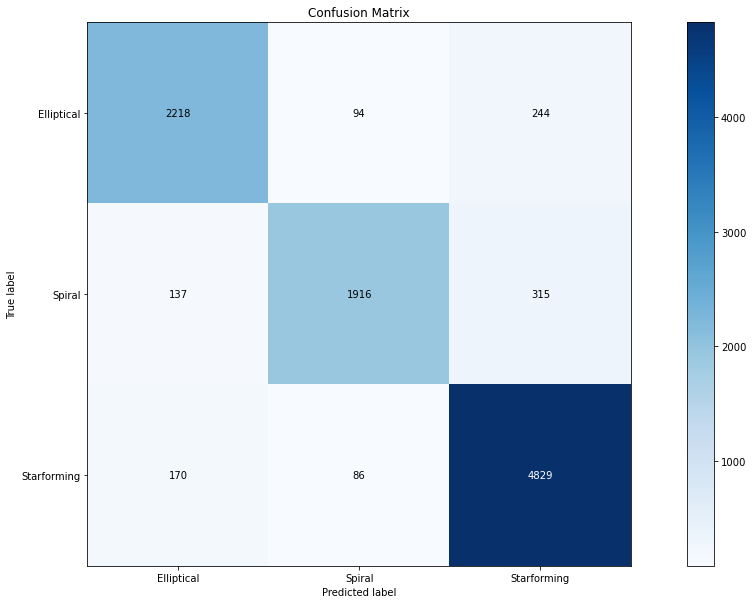

In [41]:
plt.figure()
plot_confusion_matrix(gal_types[merged['GAL_TYPE']], gal_types[t['MC_COUNT_GAL_TYPE'].argmax(axis=1)])
plt.show()

<Figure size 1440x720 with 0 Axes>

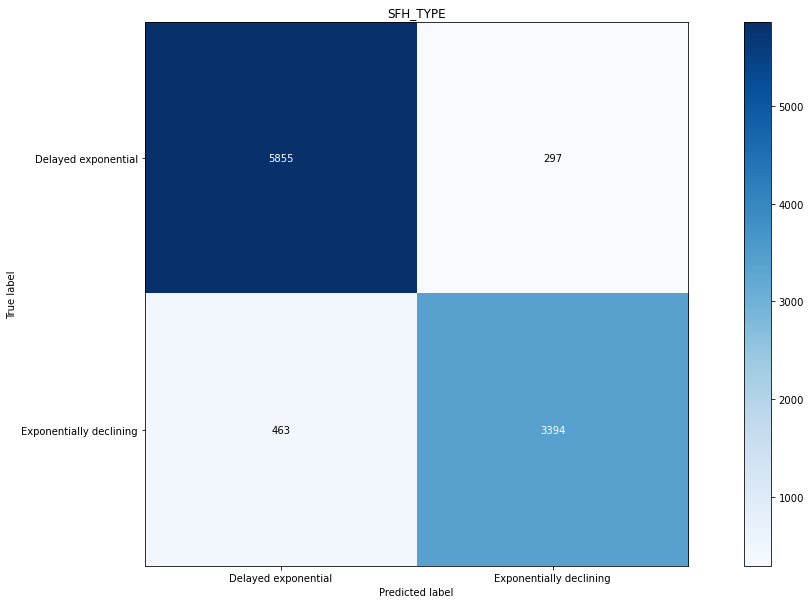

In [45]:
plt.figure()
plot_confusion_matrix(sfh_types[merged['SFH_TYPE']], sfh_types[t['MC_COUNT_SFH_TYPE'].argmax(axis=1)])
plt.title('SFH_TYPE')
plt.show()

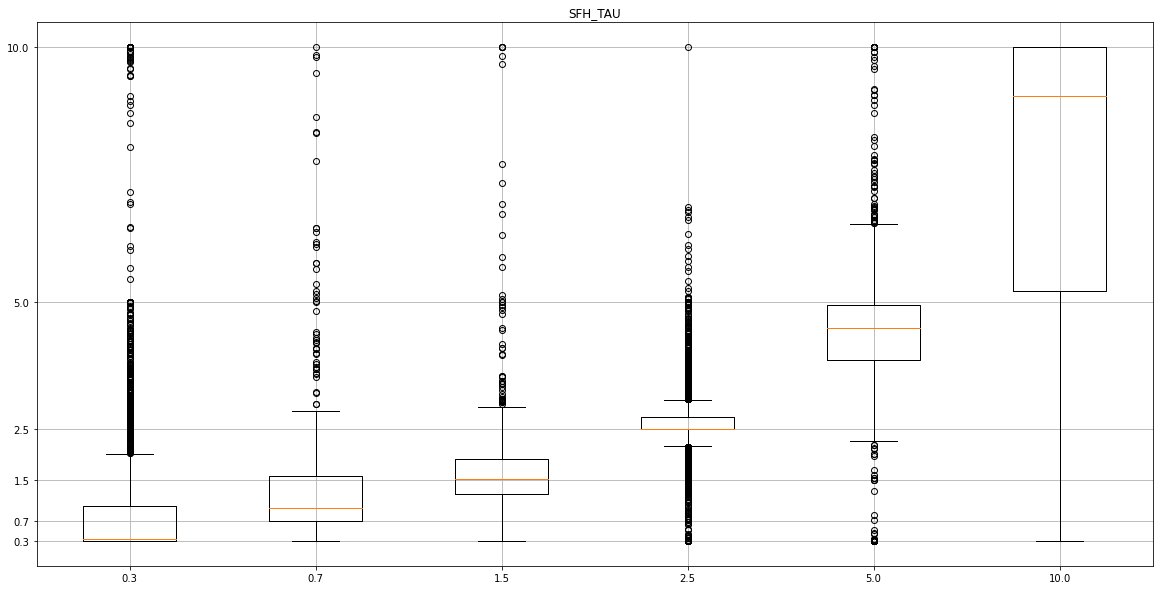

In [46]:
tau_best = t['MC_SLICE_AGGREGATE_SFH_TAU_SFH_TYPE_AVG'][np.arange(len(t)),t['MC_COUNT_SFH_TYPE'].argmax(axis=1)]
predefined_tau = [0.3, 0.7, 1.5, 2.5, 5.0, 10.0]
tau_groups = []
for i in predefined_tau:
    match = np.isclose(merged['SFH_TAU'], i)
    tau_groups.append(tau_best[match])

plt.figure()
plt.boxplot(tau_groups, labels=predefined_tau)
plt.yticks(predefined_tau)
plt.grid(True)
plt.title('SFH_TAU')
plt.show()